In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import plotnine as pn
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(5,5), transparent=True, format="pdf")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
PIL                 8.1.1
adjustText          NA
anndata             0.7.5
anyio               NA
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
descartes           NA
fasteners           NA
future_fstrings     NA
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_gen

In [49]:
ileum_infection_sc = sc.read_h5ad(filename="./../../../pyobjs_github/ileum_infection_sc.h5ad")

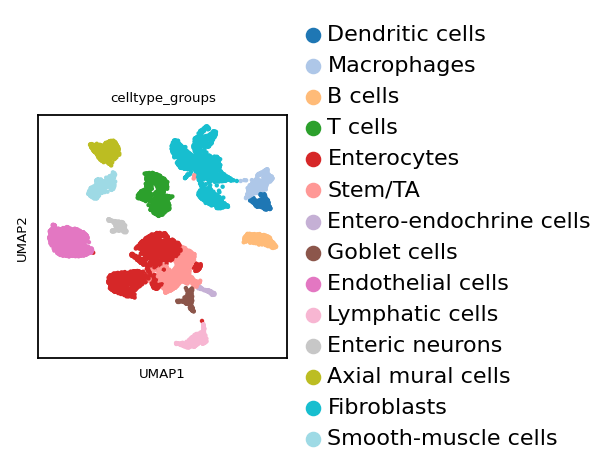

In [50]:
sc.pl.umap(ileum_infection_sc, color = ['celltype_groups'], legend_fontsize=10)

In [51]:
T1L_WT_Ileum_D1PI_xGen = sc.read_10x_h5('./../../../scData/sc_xGen21/Ileum_T1L_D1PI_xGen/outs/filtered_feature_bc_matrix.h5')
T1L_WT_Ileum_D4PI_xGen = sc.read_10x_h5('./../../../scData/sc_xGen21/Ileum_T1L_D4PI_xGen/outs/filtered_feature_bc_matrix.h5')

T1L_WT_Ileum_D1PI_xGen.var_names_make_unique()
T1L_WT_Ileum_D4PI_xGen.var_names_make_unique()

samples_xGen = ["Ileum_T1L-WT_D1PI", "Ileum_T1L-WT_D4PI"]

total_ileum_sc_xGen_subset = T1L_WT_Ileum_D1PI_xGen.concatenate(T1L_WT_Ileum_D4PI_xGen, 
                                                    batch_key= "sample", batch_categories=samples_xGen,
                                                    index_unique="-")

reading ./../../../scData/sc_xGen21/Ileum_T1L_D1PI_xGen/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../../../scData/sc_xGen21/Ileum_T1L_D4PI_xGen/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [52]:
reoviral_genes = [name for name in total_ileum_sc_xGen_subset.var_names if name.startswith('Reo')]
print(reoviral_genes)

viral_expression = total_ileum_sc_xGen_subset[:,reoviral_genes].to_df()
viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
viral_expression.columns = [name + "_xGen" for name in viral_expression.columns]

print(ileum_infection_sc.obs.shape)
ileum_infection_sc.obs = ileum_infection_sc.obs.join(viral_expression)
print(ileum_infection_sc.obs.shape)
ileum_infection_sc.obs['total_viral_xGen'] = viral_expression.sum(axis=1).astype(int)
ileum_infection_sc.obs['pct_viral_xGen'] = ((ileum_infection_sc.obs['total_viral_xGen']) / (ileum_infection_sc.obs['total_viral_xGen'] + ileum_infection_sc.obs['total_counts']))

ileum_infection_sc.obs['total_viral_NA'] = ileum_infection_sc.obs['total_viral']
ileum_infection_sc.obs['total_viral_xGen_NA'] = ileum_infection_sc.obs['total_viral_xGen']
ileum_infection_sc.obs['total_viral_NA'][ileum_infection_sc.obs['total_viral_NA']==0] = np.nan
ileum_infection_sc.obs['total_viral_xGen_NA'][ileum_infection_sc.obs['total_viral_xGen_NA']==0] = np.nan
ileum_infection_sc.obs["total_viral_xGen"][ileum_infection_sc.obs['total_viral_xGen'].isnull()] = 0

['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(7695, 31)
(7695, 41)


<ipython-input-52-013158f714c9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-52-013158f714c9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-52-013158f714c9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
ileum_infection_sc.obs["total_viral_xGen_thresh5"] = ileum_infection_sc.obs["total_viral_xGen_NA"]
ileum_infection_sc.obs["total_viral_xGen_thresh5"][(ileum_infection_sc.obs["total_viral_xGen_thresh5"] < 5)] = np.NaN

ileum_infection_sc.obs['pct_viral_xGen_thresh5'] = ((ileum_infection_sc.obs['total_viral_xGen_thresh5']) / (ileum_infection_sc.obs['total_viral_xGen_thresh5'] + ileum_infection_sc.obs['total_counts'])) * 100

<ipython-input-53-c49d4172dd8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


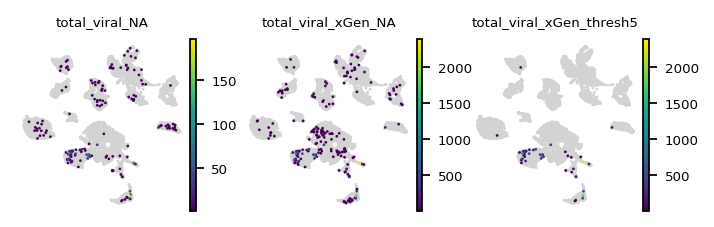

In [71]:
sc.settings.set_figure_params(dpi=80, dpi_save= 600, fontsize=6, facecolor='white', frameon=True, figsize=(1.4, 1.4), transparent=True, vector_friendly=False, format="pdf")
sc.pl.umap(ileum_infection_sc, color=["total_viral_NA",  "total_viral_xGen_NA", "total_viral_xGen_thresh5"], size = 6, ncols=3, palette='viridis_r', frameon=False, wspace=0.2, save="ileum_viral_trop_umap_xgen.pdf")

In [55]:
# ileum_infection_sc.write_h5ad(filename="./../../../pyobjs_github/ileum_infection_sc_with_xGen_filtered.h5ad")

In [3]:
ileum_infection_sc = sc.read_h5ad(filename="./../../../pyobjs_github/ileum_infection_sc_with_xGen_filtered.h5ad")
ileum_infection_sc

AnnData object with n_obs × n_vars = 7695 × 3393
    obs: 'sample', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral', 'stage', 'state', 'condition', 'n_genes', 'S_score', 'G2M_score', 'phase', 'umap_density_condition', 'leiden_0.5', 'leiden_0.3', 'celltypes_leiden_0.5', 'celltype_groups', 'condition_new', 'T1LReoS1_xGen', 'T1LReoS2_xGen', 'T1LReoS3_xGen', 'T1LReoS4_xGen', 'T1LReoM1_xGen', 'T1LReoM2_xGen', 'T1LReoM3_xGen', 'T1LReoL1_xGen', 'T1LReoL2_xGen', 'T1LReoL3_xGen', 'total_viral_xGen', 'pct_viral_xGen', 'total_viral_NA', 'total_viral_xGen_NA', 'total_viral_xGen_thresh5', 'pct_viral_xGen_thresh5'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'me

In [4]:
ileum_infection_sc.obs["viral_exp"] = ileum_infection_sc.obs["total_viral_xGen_thresh5"]
mean_viral_exp = ileum_infection_sc.obs[["condition", "celltype_groups", "viral_exp"]].groupby(["condition", "celltype_groups"]).mean()["viral_exp"]
celltype_counts = ileum_infection_sc.obs.value_counts(subset=["condition", "celltype_groups"], sort=False)
infected_cells_only = ileum_infection_sc[ileum_infection_sc.obs["viral_exp"] >= 0, :]
infected_celltypes_counts = infected_cells_only.obs.value_counts(subset=["condition", "celltype_groups"], sort=False)
count_data = pd.DataFrame({'mean_viral_exp': mean_viral_exp, 'total_counts': celltype_counts, 'infected_counts': infected_celltypes_counts})
count_data["pct_cells"] = round(((count_data["infected_counts"]/count_data["total_counts"]) * 100), 2)
count_data = count_data.iloc[count_data.index.get_level_values('condition').isin(["T1L-WT_D1PI", "T1L-WT_D4PI"])]
celltype_counts = count_data.unstack("celltype_groups")
celltype_counts = celltype_counts.reindex(["T1L-WT_D1PI", "T1L-WT_D4PI"])
celltype_counts =  celltype_counts.reindex(ileum_infection_sc.obs["celltype_groups"].cat.categories, level=1, axis= 1)
celltype_counts

mean_viral_exp                                          \
celltype_groups Dendritic cells Macrophages B cells T cells Enterocytes   
condition                                                                 
T1L-WT_D1PI                 NaN         NaN   170.0     NaN  263.703704   
T1L-WT_D4PI                 NaN         NaN     NaN     NaN         NaN   

                                                              \
celltype_groups Stem/TA Entero-endochrine cells Goblet cells   
condition                                                      
T1L-WT_D1PI        7.75                  1276.0        57.25   
T1L-WT_D4PI         NaN                     NaN          NaN   

                                                   ...   pct_cells          \
celltype_groups Endothelial cells Lymphatic cells  ... Enterocytes Stem/TA   
condition                                          ...                       
T1L-WT_D1PI                  26.0             NaN  ...        4.38    1.04   
T1L-WT_D4PI                   NaN           586.6  ...         NaN     NaN   

                                                                        \
celltype_groups Entero-endochrine cells Goblet cells Endothelial cells   
condition                                                                
T1L-WT_D1PI                        10.0         5.41              0.36   
T1L-WT_D4PI                         NaN          NaN               NaN   

                                                                               \
celltype_groups Lymphatic cells Enteric neurons Axial mural cells Fibroblasts   
condition                                                                       
T1L-WT_D1PI                 NaN             NaN               0.7         NaN   
T1L-WT_D4PI                5.15             NaN               NaN         NaN   

                                     
celltype_groups Smooth-muscle cells  
condition                            
T1L-WT_D1PI                     NaN  
T1L-WT_D4PI                     NaN  

[2 rows x 56 columns]

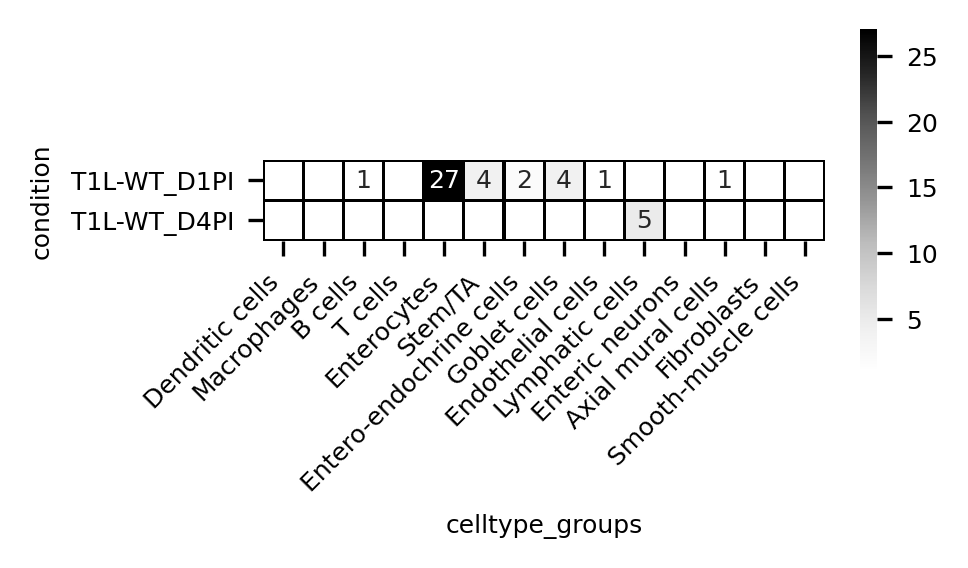

In [72]:
sc.settings.set_figure_params(dpi=150, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=False, format="pdf")
fig, ax = plt.subplots(figsize=(3.0, 1.5))
plt.rc('font', size=6)
# ax.set_axisbelow(True)
# plt.grid(False)
sns.heatmap(celltype_counts["infected_counts"], annot=True, square=True, ax=ax, linewidths=.5, linecolor= "black", cmap="Greys")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.savefig("./figures/ileum_infected_counts.pdf")

In [6]:
celltype_counts["infected_counts"].to_csv("./../../../csvs_github/ileum_infected_counts.csv")

In [58]:
celltype_counts["mean_viral_exp"].to_csv("./../../../csvs_github/ileum_mean_viral_exp.csv")
celltype_counts["pct_cells"].to_csv("./../../../csvs_github/ileum_pct_cells.csv")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


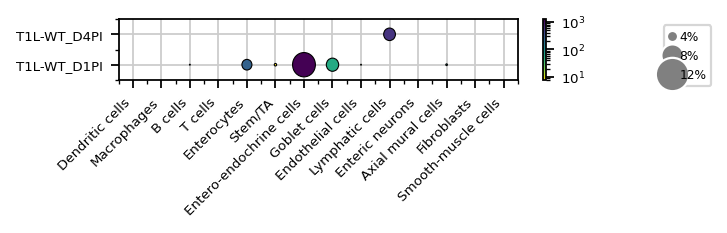

In [87]:
sc.settings.set_figure_params(dpi=80, dpi_save= 600, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), transparent=True, vector_friendly=False, format="pdf")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
plt.rcParams['axes.axisbelow'] = True

N = celltype_counts["pct_cells"].shape[0]
M = celltype_counts["pct_cells"].shape[1]
ylabels = celltype_counts["pct_cells"].index
xlabels = celltype_counts["pct_cells"].columns

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = celltype_counts["pct_cells"].to_numpy()
c = celltype_counts["mean_viral_exp"].to_numpy()
# print(c.flatten())
# print(s.flatten())

fig, ax = plt.subplots(figsize=(4.0,0.5))

R = (s/100.0)*4
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="viridis_r", edgecolor = "black", linewidth = 0.5)
col.set_clim([np.nanmin(c), np.nanmax(c)])
import matplotlib.colors as colors
col.norm=colors.LogNorm()
col.set_clim([np.nanmin(c), np.nanmax(c)])

ax.add_collection(col)
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.colorbar(col)

from matplotlib.lines import Line2D
line1 = Line2D(range(1), range(1), color="white", marker='o', markersize=5, markerfacecolor="grey")
line2 = Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor="grey")
line3 = Line2D(range(1), range(1), color="white", marker='o', markersize=15, markerfacecolor="grey")
plt.legend((line1,line2,line3),('4%','8%', "12%"),numpoints=1, bbox_to_anchor = (1.5,1.0))

plt.savefig("figures/viral_exp_allsamples_ileum_dotplot.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)

In [ ]:
## This section is used for estimation of viral UMI filtering threshold for ileum xGen data

In [12]:
Mock_Ileum_D1PI_sc = sc.read_10x_h5('./../../../scData/Ileum_Mock_D1PI/outs/raw_feature_bc_matrix.h5')
T1L_Ileum_D1PI_sc = sc.read_10x_h5('./../../../scData/Ileum_T1L-WT_D1PI/outs/raw_feature_bc_matrix.h5')
Mock_Ileum_D4PI_sc = sc.read_10x_h5('./../../../scData/Ileum_Mock_D4PI/outs/raw_feature_bc_matrix.h5')
T1L_Ileum_D4PI_sc = sc.read_10x_h5('./../../../scData/Ileum_T1L-WT_D4PI/outs/raw_feature_bc_matrix.h5')

Mock_Ileum_D1PI_sc.var_names_make_unique()
T1L_Ileum_D1PI_sc.var_names_make_unique()
Mock_Ileum_D4PI_sc.var_names_make_unique()
T1L_Ileum_D4PI_sc.var_names_make_unique()

reading ./../../../scData/Ileum_Mock_D1PI/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../../../scData/Ileum_T1L-WT_D1PI/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../../../scData/Ileum_Mock_D4PI/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../../../scData/Ileum_T1L-WT_D4PI/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:02)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
ileum_infection_sc_4samples = T1L_Ileum_D1PI_sc.concatenate(T1L_Ileum_D4PI_sc,
                                                    batch_key= "sample", 
                                                    batch_categories=["Ileum_T1L-WT_D1PI", "Ileum_T1L-WT_D4PI"],
                                                    index_unique="-")
ileum_infection_sc_4samples.obs_names_make_unique()
ileum_infection_sc_4samples.var_names_make_unique()
print(ileum_infection_sc_4samples.shape)

(2991872, 54848)


In [14]:
reoviral_genes = [name for name in ileum_infection_sc_4samples.var_names if name.startswith('Reo')]
print(reoviral_genes)

viral_expression = ileum_infection_sc_4samples[:,reoviral_genes].to_df()
viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
reoviral_genes_indicator = np.in1d(ileum_infection_sc_4samples.var_names, reoviral_genes)
ileum_infection_sc_4samples_no_viral_genes = ileum_infection_sc_4samples[:, ~reoviral_genes_indicator]
ileum_infection_sc_4samples_no_viral_genes.var_names = [name.split("_")[1] for name in ileum_infection_sc_4samples_no_viral_genes.var_names]
ileum_infection_sc_4samples_no_viral_genes.obs = ileum_infection_sc_4samples_no_viral_genes.obs.join(viral_expression.astype(int))
print(ileum_infection_sc_4samples_no_viral_genes.shape)

['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(2991872, 54838)


In [15]:
temp_dataset_no_viral_genes  = ileum_infection_sc_4samples_no_viral_genes
temp_dataset_no_viral_genes.var['mt'] = temp_dataset_no_viral_genes.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(temp_dataset_no_viral_genes, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [16]:
data = pd.DataFrame({"cell_barcode":temp_dataset_no_viral_genes.obs_names, "total_counts":temp_dataset_no_viral_genes.obs["total_counts"], "sample":temp_dataset_no_viral_genes.obs["sample"]})
data["Gapdh"] = temp_dataset_no_viral_genes[:,"Gapdh"].to_df()
data["Hba-a1"] = temp_dataset_no_viral_genes[:,"Hba-a1"].to_df()
data["cell_in_droplet"] = ["Viable cells" if data.loc[x, "total_counts"] > 200 else "Dead cells" for x in data["cell_barcode"]]
data["cell_in_droplet"] = ["Empty Droplets" if data.loc[x, "total_counts"] < 1 else data.loc[x, "cell_in_droplet"] for x in data["cell_barcode"]]
data["total_counts"] = data["total_counts"] + 1
data["Gapdh"] = data["Gapdh"] + 1
data["Hba-a1"] = data["Hba-a1"] + 1
print(data.shape)
print(data["cell_in_droplet"].value_counts())

(2991872, 6)
Empty Droplets    1678220
Dead cells        1294879
Viable cells        18773
Name: cell_in_droplet, dtype: int64


In [17]:
data = data.sort_values(by="total_counts", ascending=False)
data["cell_number"] = [i for i in range(temp_dataset_no_viral_genes.shape[0])]
data["cell_number"] = np.log10(data["cell_number"] + 1) + 1

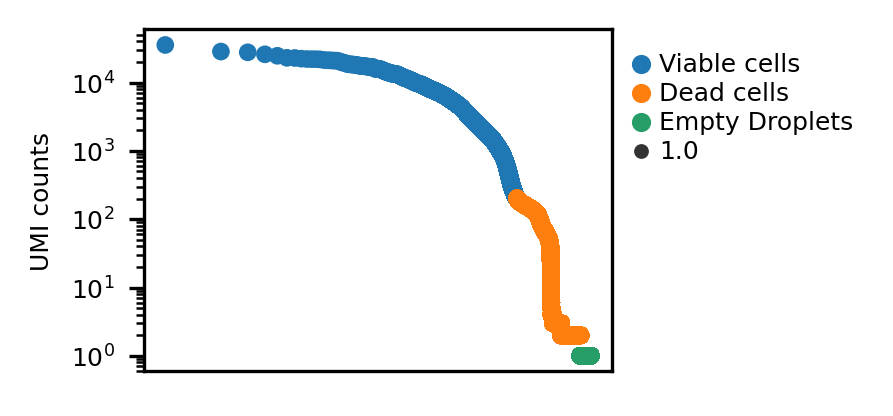

In [18]:
sc.settings.set_figure_params(dpi=150, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=False, format="pdf")
fig, ax = plt.subplots(figsize=(2, 1.5))
plt.rc('font', size=6)
ax.set_axisbelow(True)
plt.grid(False)
plt.xlabel("Droplets")
plt.ylabel("UMI counts")
sns.scatterplot(data = data, x = "cell_number", y = "total_counts", hue = "cell_in_droplet", linewidth = 0, size = 1.0, rasterized=True, ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set(yscale = "log", xscale = "log")
ax.axes.xaxis.set_visible(False)
# ax.axes.xaxis.set_ticks([])
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2, bbox_to_anchor = (1.0,1.0))
# plt.tight_layout()
plt.savefig("./figures/knee_totalUMI_ileum.pdf")

In [19]:
T1L_WT_Ileum_D1PI_xGen = sc.read_10x_h5('./../../../scData/sc_xGen21/Ileum_T1L_D1PI_xGen/outs/raw_feature_bc_matrix.h5')
T1L_WT_Ileum_D4PI_xGen = sc.read_10x_h5('./../../../scData/sc_xGen21/Ileum_T1L_D4PI_xGen/outs/raw_feature_bc_matrix.h5')

T1L_WT_Ileum_D1PI_xGen.var_names_make_unique()
T1L_WT_Ileum_D4PI_xGen.var_names_make_unique()

samples_xGen = ["Ileum_T1L-WT_D1PI", "Ileum_T1L-WT_D4PI"]

total_ileum_sc_xGen = T1L_WT_Ileum_D1PI_xGen.concatenate(T1L_WT_Ileum_D4PI_xGen, 
                                                    batch_key= "sample", batch_categories=samples_xGen,
                                                    index_unique="-")
total_ileum_sc_xGen.obs_names_make_unique()
total_ileum_sc_xGen.var_names_make_unique()
print(total_ileum_sc_xGen.shape)

reading ./../../../scData/sc_xGen21/Ileum_T1L_D1PI_xGen/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./../../../scData/sc_xGen21/Ileum_T1L_D4PI_xGen/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(75802, 54848)


In [20]:
reoviral_genes = [name for name in total_ileum_sc_xGen.var_names if name.startswith('Reo')]
print(reoviral_genes)

viral_expression = total_ileum_sc_xGen[:,reoviral_genes].to_df()
viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
reoviral_genes_indicator = np.in1d(total_ileum_sc_xGen.var_names, reoviral_genes)
total_ileum_sc_xGen = total_ileum_sc_xGen[:, reoviral_genes_indicator]
total_ileum_sc_xGen.var_names = [name.split("_")[1] for name in total_ileum_sc_xGen.var_names]
total_ileum_sc_xGen.obs = total_ileum_sc_xGen.obs.join(viral_expression.astype(int))
print(total_ileum_sc_xGen.shape)

['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(75802, 10)


In [21]:
temp_dataset_viral_genes  = total_ileum_sc_xGen
temp_dataset_viral_genes.var['mt'] = temp_dataset_viral_genes.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(temp_dataset_viral_genes, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [22]:
viral_data = pd.DataFrame({"cell_barcode":temp_dataset_viral_genes.obs_names, "sample":temp_dataset_viral_genes.obs["sample"], "total_viral_counts":temp_dataset_viral_genes.obs["total_counts"]})
viral_data = viral_data.sort_values(by="total_viral_counts", ascending=False)
viral_data["cell_number"] = [i+1 for i in range(viral_data.shape[0])]
viral_data["cell_number"] = np.log10(viral_data["cell_number"]+1) + 1

# viral_data = viral_data[viral_data["cell_barcode"].isin(data["cell_barcode"])]
print(viral_data.shape)

# viral_data["cell_in_droplet"] = [data.loc[x,"cell_in_droplet"] for x in viral_data.index]
# viral_data["total_counts"] = [data.loc[x,"total_counts"] for x in viral_data.index]
# viral_data["Gapdh"] = [data.loc[x,"Gapdh"] for x in viral_data.index]

# print(viral_data["cell_in_droplet"].value_counts())

data["total_viral_counts"] = [viral_data.loc[x, "total_viral_counts"] if x in viral_data.index else 0 for x in data.index]
data["total_viral_counts"] = data["total_viral_counts"] + 1

(75802, 4)


In [23]:
data = data.sort_values(by="total_viral_counts", ascending=False)
data["cell_number"] = [i for i in range(temp_dataset_no_viral_genes.shape[0])]
data["cell_number"] = np.log10(data["cell_number"] + 1) + 1

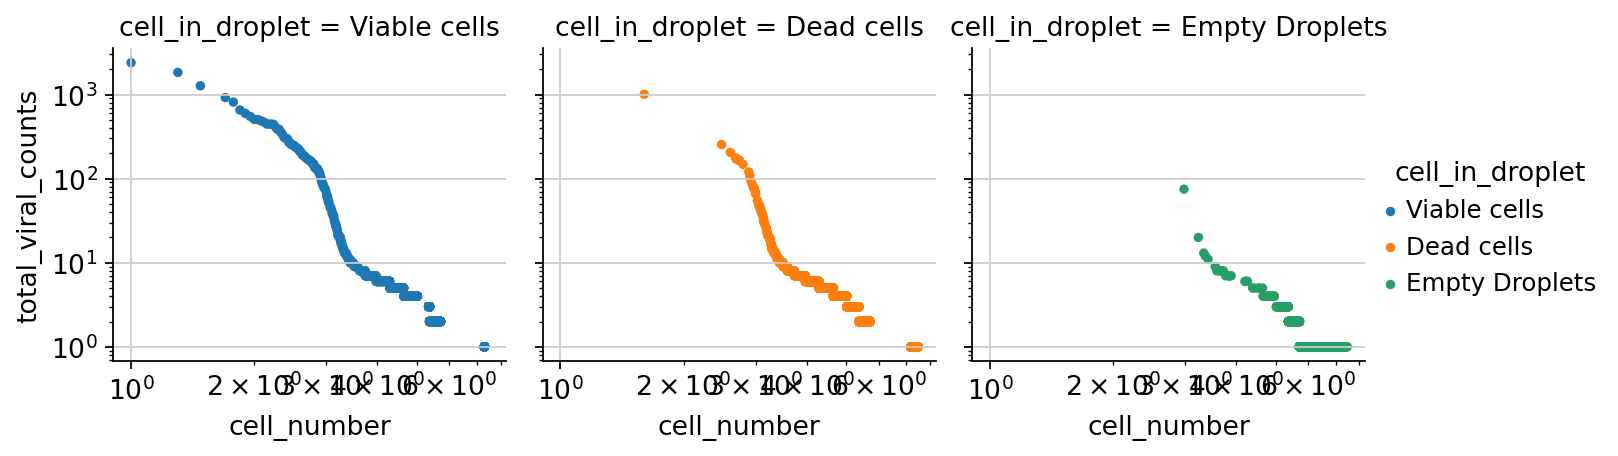

In [25]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=12, facecolor='white', frameon=True, figsize=(10, 10), transparent=True, format="pdf")
g = sns.FacetGrid(data, col="cell_in_droplet", hue="cell_in_droplet")
g.map(sns.scatterplot, "cell_number", "total_viral_counts", linewidth = 0, size = 1.0).set(yscale = "log", xscale = "log")
g.add_legend()

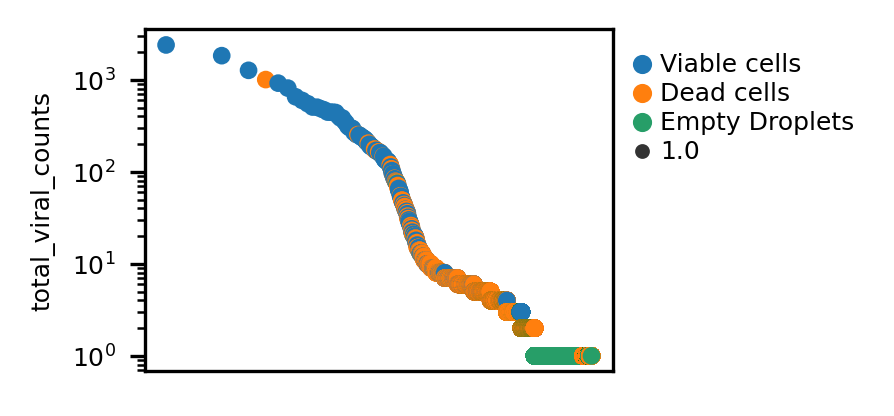

In [24]:
sc.settings.set_figure_params(dpi=150, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=False, format="pdf")
fig, ax = plt.subplots(figsize=(2, 1.5))
plt.rc('font', size=6)
plt.grid(False)
plt.xlabel("Viral UMI counts")
plt.xlabel("Droplets")
sns.scatterplot(data = data, x = "cell_number", y = "total_viral_counts", hue = "cell_in_droplet", linewidth = 0, size = 1.0, rasterized=True, ax=ax)
ax.set(yscale = "log", xscale = "log")
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2, bbox_to_anchor = (1.0,1.0))
ax.axes.xaxis.set_visible(False)
# ax.axes.xaxis.set_ticks([])
# plt.tight_layout()
plt.savefig("./figures/knee_totalviralUMI_ileum.pdf")

In [ ]:
## This section combines the viral UMI plot for ileum and heart

In [73]:
celltype_counts_ileum = pd.read_csv("./../../../csvs_github/ileum_mean_viral_exp.csv", index_col=0)
celltype_counts_ileum = celltype_counts_ileum.dropna(axis= 1, how= "all")
print(celltype_counts_ileum)
celltype_counts_heart = pd.read_csv("./../../../csvs_github/heart_mean_viral_exp.csv", index_col=0)
celltype_counts_heart = celltype_counts_heart.dropna(axis= 1, how= "all")
print(celltype_counts_heart)
mean_viral_exp = celltype_counts_ileum.join(celltype_counts_heart, how = "outer", lsuffix="_Iluem", rsuffix="_Heart")
# mean_viral_exp.index = ["T1L-WT_D1PI", "T1L-WT_D4PI", "T1L-WT_D7PI",  "T1L-WT_D10PI"]
# print(mean_viral_exp)
mean_viral_exp = mean_viral_exp.reindex(["T1L-WT_D1PI", "T1L-WT_D4PI", "T1L-WT_D7PI", "T1L-WT_D10PI"])
mean_viral_exp

             B cells  Enterocytes  Stem/TA  Entero-endochrine cells  \
condition                                                             
T1L-WT_D1PI    170.0   263.703704     7.75                   1276.0   
T1L-WT_D4PI      NaN          NaN      NaN                      NaN   

             Goblet cells  Endothelial cells  Lymphatic cells  \
condition                                                       
T1L-WT_D1PI         57.25               26.0              NaN   
T1L-WT_D4PI           NaN                NaN            586.6   

             Axial mural cells  
condition                       
T1L-WT_D1PI               76.0  
T1L-WT_D4PI                NaN  
              Cardiomyocytes  Fibroblasts  Smooth muscle cells  Pericytes  \
condition                                                                   
T1L-WT_D4PI         6.666667     3.166667                  2.0   2.000000   
T1L-WT_D7PI         2.000000     2.214286                  2.0  16.333333   
T1L-WT_D10PI  

,B cells_Iluem,Enterocytes,Stem/TA,Entero-endochrine cells,Goblet cells,Endothelial cells_Iluem,Lymphatic cells,Axial mural cells,Cardiomyocytes,Fibroblasts,...,Endocardial cells,Endothelial cells_Heart,Pericardial cells,Dendritic cells,Macrophages,B cells_Heart,NK cells,T cells,Neutrophils,Erythroblasts
condition,,,,,,,,,,,,,,,,,,,,,
T1L-WT_D1PI,170.0,263.703704,7.75,1276.0,57.25,26.0,NaN,76.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T1L-WT_D4PI,NaN,NaN,NaN,NaN,NaN,NaN,586.6,NaN,6.666667,3.166667,...,83.1,6.544444,NaN,2.500000,4.454545,NaN,NaN,2.000000,NaN,2.0
T1L-WT_D7PI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.214286,...,6.3,2.454545,3.0,8.352941,2.000000,2.0,2.0,3.621212,13.5,NaN
T1L-WT_D10PI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,2.000000,NaN,NaN


In [74]:
celltype_counts_ileum = pd.read_csv("./../../../csvs_github/ileum_pct_cells.csv", index_col=0)
celltype_counts_ileum = celltype_counts_ileum.dropna(axis= 1, how= "all")
print(celltype_counts_ileum)
celltype_counts_heart = pd.read_csv("./../../../csvs_github/heart_pct_cells.csv", index_col=0)
celltype_counts_heart = celltype_counts_heart.dropna(axis= 1, how= "all")
print(celltype_counts_heart)
pct_cells = celltype_counts_ileum.join(celltype_counts_heart, how = "outer", lsuffix="_Iluem", rsuffix="_Heart")
# pct_cells.index = ["T1L-WT_D1PI", "T1L-WT_D4PI", "T1L-WT_D7PI", "T1L-WT_D10PI"]
# print(pct_cells)
pct_cells = pct_cells.reindex(["T1L-WT_D1PI", "T1L-WT_D4PI", "T1L-WT_D7PI", "T1L-WT_D10PI"])
pct_cells

             B cells  Enterocytes  Stem/TA  Entero-endochrine cells  \
condition                                                             
T1L-WT_D1PI     0.36         4.38     1.04                     10.0   
T1L-WT_D4PI      NaN          NaN      NaN                      NaN   

             Goblet cells  Endothelial cells  Lymphatic cells  \
condition                                                       
T1L-WT_D1PI          5.41               0.36              NaN   
T1L-WT_D4PI           NaN                NaN             5.15   

             Axial mural cells  
condition                       
T1L-WT_D1PI                0.7  
T1L-WT_D4PI                NaN  
              Cardiomyocytes  Fibroblasts  Smooth muscle cells  Pericytes  \
condition                                                                   
T1L-WT_D4PI             1.95         1.44                 1.49       1.84   
T1L-WT_D7PI             3.45         2.66                 2.27       5.66   
T1L-WT_D10PI  

,B cells_Iluem,Enterocytes,Stem/TA,Entero-endochrine cells,Goblet cells,Endothelial cells_Iluem,Lymphatic cells,Axial mural cells,Cardiomyocytes,Fibroblasts,...,Endocardial cells,Endothelial cells_Heart,Pericardial cells,Dendritic cells,Macrophages,B cells_Heart,NK cells,T cells,Neutrophils,Erythroblasts
condition,,,,,,,,,,,,,,,,,,,,,
T1L-WT_D1PI,0.36,4.38,1.04,10.0,5.41,0.36,NaN,0.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T1L-WT_D4PI,NaN,NaN,NaN,NaN,NaN,NaN,5.15,NaN,1.95,1.44,...,4.42,3.79,NaN,1.40,2.96,NaN,NaN,1.96,NaN,1.19
T1L-WT_D7PI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.45,2.66,...,11.11,6.40,8.57,4.62,2.08,1.64,3.49,4.29,6.11,NaN
T1L-WT_D10PI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.49,NaN,NaN,NaN,0.15,NaN,NaN


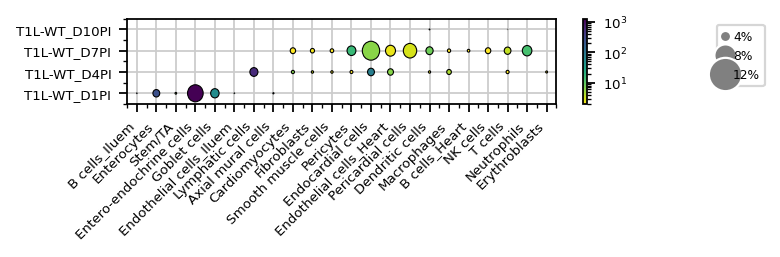

In [85]:
sc.settings.set_figure_params(dpi=80, dpi_save= 600, fontsize=6, facecolor='white', frameon=True, figsize=(2.0, 2.0), transparent=True, vector_friendly=False, format="pdf")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
plt.rcParams['axes.axisbelow'] = True

N = pct_cells.shape[0]
M = pct_cells.shape[1]
ylabels = pct_cells.index
xlabels = pct_cells.columns

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = pct_cells.to_numpy()
c = mean_viral_exp.to_numpy()
# s = pct_cells.fillna(0).to_numpy()
# c = mean_viral_exp.fillna(0).to_numpy()
# print(c.flatten())
# print(s.flatten())

fig, ax = plt.subplots(figsize=(4.3,0.7))

R = (s/100.0)*4
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="viridis_r", edgecolor = "black", linewidth = 0.5)
col.set_clim([np.nanmin(c), np.nanmax(c)])
import matplotlib.colors as colors
col.norm=colors.LogNorm()
col.set_clim([np.nanmin(c), np.nanmax(c)])

ax.add_collection(col)
ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
fig.colorbar(col)

from matplotlib.lines import Line2D
line1 = Line2D(range(1), range(1), color="white", marker='o', markersize=5, markerfacecolor="grey")
line2 = Line2D(range(1), range(1), color="white", marker='o', markersize=10, markerfacecolor="grey")
line3 = Line2D(range(1), range(1), color="white", marker='o', markersize=15, markerfacecolor="grey")
# line3 = Line2D(range(1), range(1), color="white", marker='o', markersize=, markerfacecolor="grey")
plt.legend((line1,line2,line3),('4%','8%', "12%"),numpoints=1, bbox_to_anchor = (1.5,1.0))

plt.savefig("figures/viral_exp_all_dotplot.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)